In [3]:
# Import all the necessary modules needed to run the inference pipeline
import sys
import os

sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import numpy as np
import emcee
import seaborn as sns

In [25]:
experiment = "Halfwound" # either "Single_wound" or "Halfwound" or "Two_wounds"
binningtype = "quarter" # either "half" or "quarter" (binning by py or pi/2)
filesuffix = "_s3_t2_5mins"
distance = [54, 95, 147.5] # Liepe bins: [54, 105, 195, 305, 430]; 2x bins: [54, 87.5, 122.5, 167.5, 222.5, 277.5, 332.5, 395] # halfwound bins s2 [54, 122.5]; s3 [54, 95, 147.5]
time = [7.5, 17.5] # [2.5,7.5,12.5,17.5,22.5]
time_labels = ["5-10", "15-20"]#["0-5","5-10","10-15","15-20","20-25"]
# This function reads in previously run data from walker inference pipeline, and outputs the observed bias mean and std\
# for the dataframe. The inputs are x,y which correspond to the file formats

Attempting to load ../data/BP_inference/Halfwound_MCR_revision_ctr_quarter_s3_t2_5mins_bins00.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_mcr_quarter_s3_t2_5mins_bins00.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_ctr_quarter_s3_t2_5mins_bins10.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_mcr_quarter_s3_t2_5mins_bins10.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_ctr_quarter_s3_t2_5mins_bins20.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_mcr_quarter_s3_t2_5mins_bins20.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_ctr_quarter_s3_t2_5mins_bins01.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_mcr_quarter_s3_t2_5mins_bins01.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_ctr_quarter_s3_t2_5mins_bins11.h5
Attempting to load ../data/BP_inference/Halfwound_MCR_revision_mcr_quarter_s3_t2_5mins_bins11.h5
Attempting to load ../data/BP_

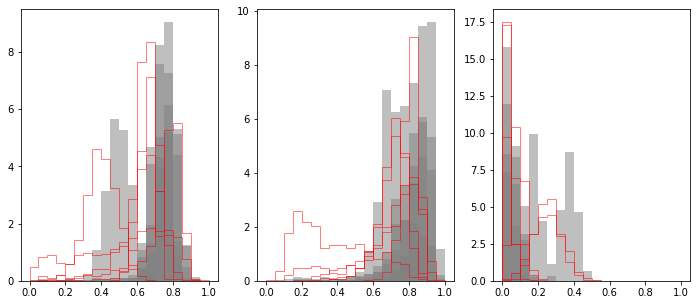

In [26]:
# calculate correlation times to estimate a burn-in and thin to use across all samples
# need to check for both CTR and MCR samples
stepSizeTimeBins = 1
nTimeBins = int(np.round(len(time_labels)/stepSizeTimeBins))
max_tau = np.ones(3)
min_tau = np.inf*np.ones(3)

# make a plot to keep trap of overall distribution of paramters
plt.figure(figsize=(12,5))
labels = ['w','p','b']

for i in range(nTimeBins):
    for j in range(len(distance)):
        print('Attempting to load ' + '../data/BP_inference/'+experiment+'_MCR_revision_ctr_'+binningtype+filesuffix+'_bins{}{}.h5'.format(j,i))
        sample_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_ctr_'+binningtype+filesuffix+'_bins{}{}.h5'.format(j,i))
        tau = sample_data.get_autocorr_time(tol=0)
        max_tau = np.max((max_tau, tau), axis=0)
        min_tau = np.min((min_tau, tau), axis=0)
        # now create plot
        this_thin = int(np.min(tau))
        this_burnin = max(3000,int(2 * np.max(tau)))
        samples = sample_data.get_chain(discard=this_burnin, thin=this_thin, flat=True)
        for dim in range(3):
            plt.subplot(1,3,dim+1)
            plt.hist(samples[:,dim], bins=20, range=(0, 1), density= True, alpha=0.5, color='grey')
            # sns.kdeplot(samples[:,dim], clip=[0, 1] ,color='grey')
            if i==nTimeBins-1 & j==len(distance)-1:
                plt.xlabel(labels[dim])
                plt.ylabel('Frequency')
                plt.title('Posterior distribution of parameters')
                plt.tight_layout()
        
        # now repeat for MCR samples
        print('Attempting to load ' + '../data/BP_inference/'+experiment+'_MCR_revision_mcr_'+binningtype+filesuffix+'_bins{}{}.h5'.format(j,i))
        sample_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_mcr_'+binningtype+filesuffix+'_bins{}{}.h5'.format(j,i))
        tau = sample_data.get_autocorr_time(tol=0)
        max_tau = np.max((max_tau, tau), axis=0)
        min_tau = np.min((min_tau, tau), axis=0)
        # now create plot
        this_thin = int(np.min(tau))
        this_burnin = max(3000,int(2 * np.max(tau)))
        samples = sample_data.get_chain(discard=this_burnin, thin=this_thin, flat=True)
        for dim in range(3):
            plt.subplot(1,3,dim+1)
            plt.hist(samples[:,dim], bins=20, range=(0, 1), density= True, alpha=0.5, color='red', histtype='step')
            # sns.kdeplot(samples[:,dim], clip=[0, 1] ,color='red')
            if i==nTimeBins-1 & j==len(distance)-1:
                plt.xlabel(labels[dim])
                plt.ylabel('Frequency')
                plt.title('Posterior distribution of parameters')
                plt.tight_layout()

burnin = max(3000,int(2 * np.max(max_tau)))
thin = int(np.min(min_tau))
print("highest auto-correlation time: {0}".format(max_tau))
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

plt.show()


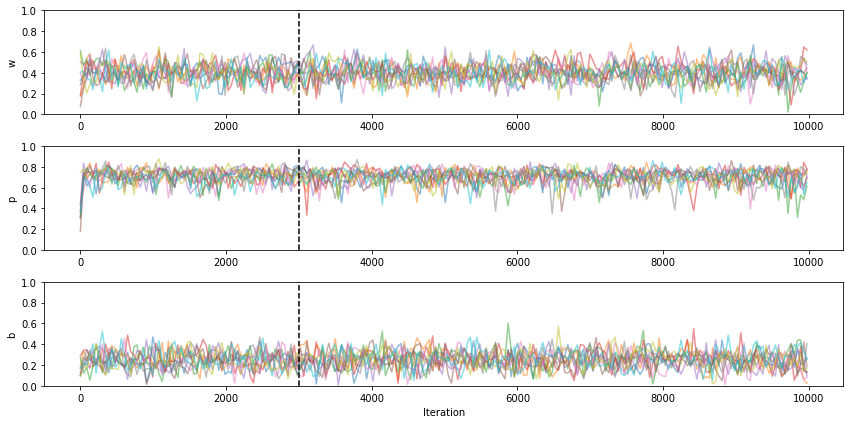

In [27]:
# plot some MCMC chains to check for a reasonable burn-in
sample_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_mcr_'+binningtype+filesuffix+'_bins00.h5')
samples = sample_data.get_chain(discard=0, thin=thin, flat=False)

labels = ['w','p','b']
ndim = samples.shape[2]
n_walkers = samples.shape[1]
n_samples = samples.shape[0]
x_iterations = np.linspace(0, n_samples*thin, n_samples)

# Trace Plots
plt.figure(figsize=(12, 6))
for dim in range(ndim):
    plt.subplot(ndim, 1, dim + 1)
    plt.plot(x_iterations, samples[:, :, dim], alpha=0.5)
    plt.plot([burnin, burnin], [0, 1], 'k--')
    plt.ylabel(labels[dim])
    plt.ylim(0, 1)
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

In [28]:
# define functions to extract the observed bias values from the data
def bias_param_samples_from_file(emcee_samples):
    # Removes the burn-in, thins the posterior data and flattens the walkers into a single array
    flattened_chain = emcee_samples.get_chain(discard=burnin, thin=thin, flat=True)
    w = flattened_chain[:, 0]  # The weighting parameter from the walker posterior array
    p = flattened_chain[:, 1]  # The weighting parameter from the walker posterior array
    b = flattened_chain[:, 2]  # The bias parameter from the walker posterior array
    observedBias = w * b  # The observed bias parameter from the walker posterior array
    observedPersistence = (1 - w) * p  # The observed persistence parameter from the walker posterior array
    mean_ob = np.mean(observedBias)
    std_ob = np.std(observedBias)
    mean_op = np.mean(observedPersistence)
    std_op = np.std(observedPersistence)
    return mean_ob, std_ob, mean_op, std_op

def bias_values_halfwound_control(i, j): 
    control_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_ctr_'+binningtype+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(control_data)

def bias_values_halfwound_mcr(i, j): 
    mcr_data = emcee.backends.HDFBackend('../data/BP_inference/'+experiment+'_MCR_revision_mcr_'+binningtype+filesuffix+'_bins{}{}.h5'.format(i,j))
    return bias_param_samples_from_file(mcr_data)

In [29]:
def reshape_observed_params(bias_persistence_values):
    reshapedBias= []
    reshapedPersistence = []
    for i in range(len(time_labels)):
        meanObservedBias = []
        stdObservedBias = []
        meanObservedPersistence = []
        stdObservedPersistence = []
        for j in range(len(distance)):
            ObBiasPers = bias_persistence_values(j, i)
            meanObservedBias.append(ObBiasPers[0])
            stdObservedBias.append(ObBiasPers[1])
            meanObservedPersistence.append(ObBiasPers[2])
            stdObservedPersistence.append(ObBiasPers[3])
        reshapedBias.append([meanObservedBias,stdObservedBias])
        reshapedPersistence.append([meanObservedPersistence,stdObservedPersistence])
    return reshapedBias, reshapedPersistence

In [30]:
reshapedBias_control, reshapedPersistence_control = reshape_observed_params(bias_values_halfwound_control)
reshapedBias_mcr, reshapedPersistence_mcr = reshape_observed_params(bias_values_halfwound_mcr)
# dimensions are N time points, [mean, std], M distances

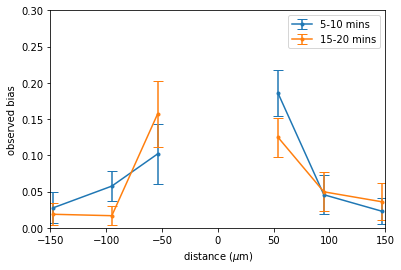

In [31]:
# Define a color cycle
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create an iterator from the color cycle
color_iter = iter(color_cycle)

for t_index, time_label in enumerate(time_labels):
    # plot both of the next lines in the same colour
    color = next(color_iter)
    plt.errorbar(np.array(distance), reshapedBias_control[t_index][0], 
                 yerr=reshapedBias_control[t_index][1],marker='o',markersize = 3,capsize = 5, color=color, label = time_label+ " mins")
    plt.errorbar(-np.array(distance), reshapedBias_mcr[t_index][0], 
                yerr=reshapedBias_mcr[t_index][1],marker='o',markersize = 3,color=color, capsize = 5)
    
plt.legend()
plt.ylim(0,0.3)
plt.xlim(-150,150)
plt.xlabel("distance ($\mu$m)")
plt.ylabel("observed bias")
plt.savefig("Figures/ObservedBiasPlots/Observed_bias_"+experiment+"_mcr_"+binningtype+filesuffix+".pdf")

plt.show()